In this file we will compute molecular fingerprints as bit vectors and save them in a dataframe

First we import the necessary modules

In [227]:
#import basic python packages
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq

#import sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, matthews_corrcoef
from scipy.stats import randint

#import rdkit packages
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import Descriptors, AllChem, PandasTools

First we read the file moleculus combined, which contains the smiles string and ALDH1_inhibition

In [190]:
filename = 'Molecules_combined.csv'
df = pd.read_csv(filename)
df.head()

,SMILES,ALDH1_inhibition
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1


Now we add a new column with RDKit molecules and switch the columns around + we will remove duplicates

In [191]:
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')
df = df[['SMILES','Molecule','ALDH1_inhibition']]
df.drop_duplicates(subset=['SMILES'],inplace=True)
df = df.reset_index(drop=True)
df

,SMILES,Molecule,ALDH1_inhibition
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,<rdkit.Chem.rdchem.Mol object at 0x000001EBAC4...,1
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,<rdkit.Chem.rdchem.Mol object at 0x000001EBAC4...,1
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,<rdkit.Chem.rdchem.Mol object at 0x000001EBAC4...,1
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,<rdkit.Chem.rdchem.Mol object at 0x000001EBA0E...,1
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,<rdkit.Chem.rdchem.Mol object at 0x000001EBA0E...,1
...,...,...,...
1970,C/C(=N\NC(=S)Nc1ccc(F)cc1)C1CC1,<rdkit.Chem.rdchem.Mol object at 0x000001EBA0F...,1
1971,COC(=O)c1c(NC(C)=O)sc2c1CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x000001EBA0F...,1
1972,O=C(CCl)NC1CCCc2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x000001EBA0F...,1
1973,COc1ccc(-n2c(SCC(=O)N3CCCCC3C)nnc2-c2cccnc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000001EBA0F...,1


Check whether all smiles strings could be converted to molecules

In [192]:
#Print the amount of 0 values in the molecule column.
df.Molecule.isna().sum()

0

No 0 values so no need to drop any rows
Now we use the RDKit molecule objects to calculate the morgan fingerprint of each molecule

First we make a list of molecules. Then we turn this into a list of morgan fingerprint (radius =2) bitvectors and store them in a new dataframe

In [193]:
#create list of molecules from dataframe
mol_list = df['Molecule'].tolist()

#Calculate morgan fingerprints 
morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mol_list]

#Store the bits of the morgan fingerprint in a new dataframe
morgan_fp_list = [list(i) for i in morgan_fp]
fp_df = pd.DataFrame(morgan_fp_list)

#Rename columns
bitnumbers = [i for i in range(1,2049)]
fp_df.columns = bitnumbers
fp_df

      1     2     3     4     5     6     7     8     9     10    ...  2039  \
0        0     1     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     1     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1970     0     0     0     0     0     0     0     0     0     0  ...     0   
1971     0     0     1     0     0     0     0     0     0     0  ...     0   
1972     0     0     0     0     0     0     0     0     0     0  ...     0   
1973     0     0     0     0     0     0     0     0     0     0  ...     0   
1974     0     0     0     0     0     1     0     0     0     0  ...     0   

      2040  2041  2042  2043  2044  2045  2046  204

Now we create a new dataframe combining the smiles strings and the morgan fingerprint bits and save this as a csv file

In [194]:
smiles_column_df = df.iloc[:,0].to_frame()
df_smiles_fp = smiles_column_df.merge(fp_df,left_index=True, right_index=True)
df_smiles_fp.head()
df_smiles_fp.to_csv('desciptors_fingerprints.csv')

Load the PC's computed in 'data preparatio for ML' and combine it in a new dataframe with the fingerpring vectors

In [195]:
csv_file = "reduced_scaled_list_of_molecs_v2.csv"
data = pd.read_csv(csv_file, header = 0)
data = data.drop(data.columns[0], axis=1)

data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,ALDH1_inhibition
0,0.873691,1.011789,-0.182139,-0.223956,0.492136,0.135993,-0.127539,0.019637,-0.268770,0.096624,...,0.194245,-0.039295,-0.026117,0.195499,-0.112998,-0.188653,-0.057517,-0.001167,0.119534,Yes
1,-0.070396,0.836068,0.068009,-0.372655,-0.195054,0.073084,-0.009113,0.026222,0.142134,-0.404668,...,0.138816,0.109786,0.078531,-0.168753,0.208380,-0.109078,-0.066451,0.070565,-0.050424,Yes
2,0.568791,1.049937,-0.180732,-0.860063,0.427130,-0.503204,-0.012247,0.523686,0.085882,-0.498935,...,-0.165430,-0.001814,-0.016709,0.321922,0.046222,0.034103,-0.252086,0.010067,0.177005,Yes
3,-0.358623,-0.421055,0.059214,-0.008505,-0.312905,0.392098,0.258758,0.156754,0.273009,0.205335,...,-0.076742,0.075923,0.206183,0.116790,-0.179684,-0.195519,-0.120440,-0.232880,-0.016757,Yes
4,0.437417,0.474394,0.312002,-0.176393,-0.255540,0.271514,0.048435,0.332471,-0.144189,0.215461,...,-0.017319,0.087436,-0.018026,-0.305317,0.168894,0.083411,0.062006,-0.065165,-0.206328,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,-0.186587,-0.648914,-0.058816,0.038799,-0.067762,0.294277,-0.237901,-0.023108,0.046342,-0.057428,...,-0.021932,0.187430,0.132610,-0.123912,-0.000884,0.004991,0.153213,-0.025980,0.178465,Yes
1971,0.295909,-0.779246,0.078668,-0.299188,-0.163151,-0.123248,0.031472,-0.241213,-0.134490,-0.093804,...,0.121846,0.062807,-0.140788,-0.076942,0.088703,-0.222874,0.008622,0.036424,-0.063983,Yes
1972,-0.251238,-0.812520,-0.297872,-0.058105,-0.245527,0.007326,-0.070354,-0.046019,-0.078041,-0.145125,...,0.211558,-0.031043,-0.142980,-0.006787,0.101109,-0.154061,-0.108262,0.058779,-0.002068,Yes
1973,0.246045,0.906731,0.045741,-0.541189,0.015966,-0.351500,0.540478,-0.029773,0.325718,-0.072111,...,0.102624,0.040162,0.254214,0.063521,0.026986,-0.059010,-0.121851,0.044665,0.148678,Yes


In [196]:
df_fp_pca = pd.concat([df_smiles_fp, data], axis=1)
df_fp_pca = df_fp_pca.drop(columns=['SMILES', 'ALDH1_inhibition'])
columnnumbers = [i for i in range(1,2082)]
df_fp_pca.columns = columnnumbers
df_fp_pca

,1,2,3,4,5,6,7,8,9,10,...,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081
0,0,1,0,0,0,0,0,0,0,0,...,-0.171541,0.194245,-0.039295,-0.026117,0.195499,-0.112998,-0.188653,-0.057517,-0.001167,0.119534
1,0,0,0,0,0,0,0,0,0,0,...,-0.042899,0.138816,0.109786,0.078531,-0.168753,0.208380,-0.109078,-0.066451,0.070565,-0.050424
2,0,1,0,0,0,0,0,0,0,0,...,-0.259082,-0.165430,-0.001814,-0.016709,0.321922,0.046222,0.034103,-0.252086,0.010067,0.177005
3,0,0,0,0,0,0,0,0,0,0,...,0.194135,-0.076742,0.075923,0.206183,0.116790,-0.179684,-0.195519,-0.120440,-0.232880,-0.016757
4,0,0,0,0,0,0,0,0,0,0,...,0.350346,-0.017319,0.087436,-0.018026,-0.305317,0.168894,0.083411,0.062006,-0.065165,-0.206328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,0,0,0,0,0,0,0,0,0,0,...,-0.077981,-0.021932,0.187430,0.132610,-0.123912,-0.000884,0.004991,0.153213,-0.025980,0.178465
1971,0,0,1,0,0,0,0,0,0,0,...,0.245726,0.121846,0.062807,-0.140788,-0.076942,0.088703,-0.222874,0.008622,0.036424,-0.063983
1972,0,0,0,0,0,0,0,0,0,0,...,0.110139,0.211558,-0.031043,-0.142980,-0.006787,0.101109,-0.154061,-0.108262,0.058779,-0.002068
1973,0,0,0,0,0,0,0,0,0,0,...,0.092746,0.102624,0.040162,0.254214,0.063521,0.026986,-0.059010,-0.121851,0.044665,0.148678


Now we will assign the discriptors to the model parameter X and the ALDH1_Inhibition to model parameter y. We will then proceed to create a 80%-20% train test split with a set seed for reproducebility

In [197]:
X = df_fp_pca
Y = df['ALDH1_inhibition']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Check the distribution between inhibiter and non inhibiters.

In [198]:
sum(Y) / len(Y)


0.3037974683544304

In [203]:
rf_model = RandomForestClassifier(max_depth=13,n_estimators=331)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, n_estimators=331)

In [204]:
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy=", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1_score=", f1)


Accuracy= 0.8253164556962025
Precision: 0.8333333333333334
Recall: 0.5371900826446281
f1_score= 0.6532663316582915


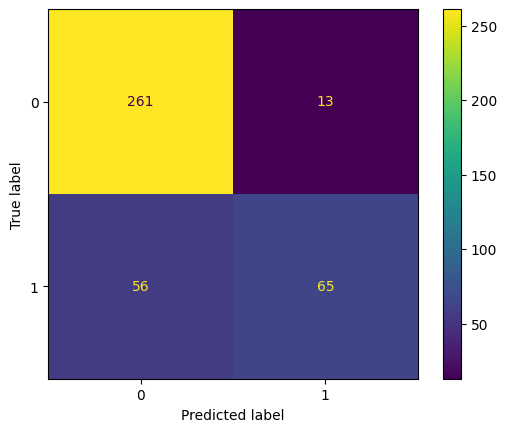

In [219]:
# Create a confusion matrix to evaluate the model
confusion_m = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=confusion_m).plot()

Test accuracy on training set

In [201]:
y_pred_train = rf_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_pred_train)
print('Accuracy on training set:',training_accuracy)

Accuracy on training set: 0.9993670886075949


Tuning Hyperparamers

In [202]:
#First we use 
parm_distribution = {'n_estimators': randint(50,500),
                    'max_depth': randint(1,20)}
rf_model = RandomForestClassifier()
randomized_parm_optimization = RandomizedSearchCV(rf_model,
                                                  param_distributions=parm_distribution,
                                                  scoring= 'f1',
                                                  n_iter=6,
                                                  cv=5)
randomized_parm_optimization.fit(X_train,y_train)

top_rf_model = randomized_parm_optimization.best_estimator_
print(top_rf_model)

RandomForestClassifier(max_depth=13, n_estimators=331)


Now we start preparing the untested molecules and use our trained random forrest model to find aldh1 inhibitors

Load the untested molecules dataset

In [206]:
filename = 'untested_molecules.csv'
df_untested = pd.read_csv(filename)
df_untested

,SMILES
0,CCCCC/C(=N\NC(=O)CCC(=O)NCc1ccccc1)c1ccccc1
1,Cc1ccc(S(=O)(=O)N2CCC(C(=O)OCC(=O)N3CCc4ccccc4...
2,COc1ccc(N2C(=O)CC(Nc3ccc(F)cc3)C2=O)c([N+](=O)...
3,Cc1cc(C)cc(OCC(=O)O[NH+]=C(N)Cc2ccc([N+](=O)[O...
4,NNC(=O)C=C1CCN(c2ncc(C(F)(F)F)cc2Cl)CC1
...,...
9995,CCNC(=O)c1nc[nH]c1C(=O)NCC
9996,CCC(C)C(NC(=O)C(C)NC(=O)CNC(=O)CNC(=O)OCc1cccc...
9997,O=C(CSc1ncnc2ccccc12)Nc1cccc(S(=O)(=O)N2CCOCC2)c1
9998,Cc1cc(OCCOCC[NH+](C)CCO)cc(C)c1Cl


Turn smiles strings into molecules and store them in the same dataset. Also check for duplicated rows and drop them.

In [207]:
PandasTools.AddMoleculeColumnToFrame(df_untested,'SMILES','Molecule')
df_untested.drop_duplicates(subset=['SMILES'],inplace=True)
df_untested = df_untested.reset_index(drop=True)
df_untested

,SMILES,Molecule
0,CCCCC/C(=N\NC(=O)CCC(=O)NCc1ccccc1)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x000001EB99E...
1,Cc1ccc(S(=O)(=O)N2CCC(C(=O)OCC(=O)N3CCc4ccccc4...,<rdkit.Chem.rdchem.Mol object at 0x000001EB99E...
2,COc1ccc(N2C(=O)CC(Nc3ccc(F)cc3)C2=O)c([N+](=O)...,<rdkit.Chem.rdchem.Mol object at 0x000001EB99E...
3,Cc1cc(C)cc(OCC(=O)O[NH+]=C(N)Cc2ccc([N+](=O)[O...,<rdkit.Chem.rdchem.Mol object at 0x000001EB99E...
4,NNC(=O)C=C1CCN(c2ncc(C(F)(F)F)cc2Cl)CC1,<rdkit.Chem.rdchem.Mol object at 0x000001EB99E...
...,...,...
9964,CCNC(=O)c1nc[nH]c1C(=O)NCC,<rdkit.Chem.rdchem.Mol object at 0x000001EB99D...
9965,CCC(C)C(NC(=O)C(C)NC(=O)CNC(=O)CNC(=O)OCc1cccc...,<rdkit.Chem.rdchem.Mol object at 0x000001EB99D...
9966,O=C(CSc1ncnc2ccccc12)Nc1cccc(S(=O)(=O)N2CCOCC2)c1,<rdkit.Chem.rdchem.Mol object at 0x000001EB99D...
9967,Cc1cc(OCCOCC[NH+](C)CCO)cc(C)c1Cl,<rdkit.Chem.rdchem.Mol object at 0x000001EB99D...


Check whether all smiles strings could be converted to molecules

In [209]:
#Print the amount of 0 values in the molecule column.
df_untested.Molecule.isna().sum()

0

First we make a list of molecules. Then we turn this into a list of morgan fingerprint (radius =2) bitvectors and store them in a new dataframe

In [210]:
#create list of molecules from dataframe
mol_list = df_untested['Molecule'].tolist()

#Calculate morgan fingerprints 
morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mol_list]

#Store the bits of the morgan fingerprint in a new dataframe
morgan_fp_list = [list(i) for i in morgan_fp]
fp_df_untested = pd.DataFrame(morgan_fp_list)

#Rename columns
bitnumbers = [i for i in range(1,2049)]
fp_df_untested.columns = bitnumbers
fp_df_untested

,1,2,3,4,5,6,7,8,9,10,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9965,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we create a new dataframe combining the morgan fingerprints and PCA results

First we load the reduced scaled list of untested molecules

In [217]:
csv_file = "reduced_scaled_list_of_untested_molecs.csv"
data_untested = pd.read_csv(csv_file, header = 0)
data_untested = data_untested.drop(data_untested.columns[0], axis=1)

data_untested

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33
0,0.264705,-0.035380,-0.734212,0.042253,-0.334140,0.114293,-0.367323,0.034094,-0.270585,-0.475224,...,0.019112,0.137160,0.106412,0.069768,0.121549,0.045777,-0.110404,-0.218882,0.075640,0.057224
1,0.896021,0.098880,-0.077974,0.172329,-0.502672,-0.195353,-0.003666,0.359869,-0.257264,0.381318,...,-0.044884,-0.074440,-0.054088,-0.007127,0.100678,-0.059102,0.229164,-0.022608,0.016921,-0.142763
2,0.723859,-0.205432,0.217959,0.393966,0.107823,-0.036598,-0.278369,-0.081905,-0.118451,0.169892,...,0.188374,-0.154732,0.443526,-0.363257,0.111364,0.327686,0.046457,-0.164639,0.050844,0.047663
3,0.497740,-0.259036,-0.184412,0.317811,0.105905,-0.046879,-0.234901,-0.127004,-0.102103,-0.349757,...,-0.013156,-0.082572,0.220970,-0.157787,0.059178,-0.087978,0.213287,0.089154,0.025531,-0.193025
4,0.248380,-0.654509,0.707747,0.070735,-0.080659,0.100295,-0.276110,0.475557,0.303163,0.201304,...,-0.045375,-0.075370,0.023025,0.015128,0.011770,-0.092893,0.013800,0.126137,0.010645,0.052837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9964,0.020729,-0.783537,0.199520,-0.339289,0.374592,-0.030632,-0.504900,-0.430618,0.095708,-0.224643,...,-0.160199,-0.013405,-0.046383,0.062624,0.046639,0.136193,-0.009248,-0.050342,-0.095663,-0.049148
9965,1.407250,-0.226398,0.105831,0.073967,0.403355,0.316681,-0.386715,-0.401271,-0.424372,-0.604003,...,0.310731,-0.089131,0.113009,-0.046511,0.302468,0.131955,-0.159522,0.081270,0.143940,0.042307
9966,0.538169,0.451513,0.295943,-0.040919,-0.171358,0.162549,0.074533,0.632897,-0.289320,0.210618,...,0.041557,0.020008,0.295602,-0.026589,0.206491,0.128611,-0.095513,0.108635,-0.004203,-0.087107
9967,0.158742,-0.791119,-0.405481,0.028251,0.631126,0.025393,0.508849,0.425807,0.203993,-0.427586,...,0.052538,-0.166707,0.215033,-0.212642,0.310644,0.115416,0.232212,0.008466,0.127079,-0.137654


Now we merge both dataframes together

In [218]:
df_untested_final = pd.concat([fp_df_untested, data_untested], axis=1)
columnnumbers = [i for i in range(1,2082)]
df_untested_final.columns = columnnumbers
df_untested_final

,1,2,3,4,5,6,7,8,9,10,...,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081
0,0,0,0,0,0,0,0,0,0,0,...,0.019112,0.137160,0.106412,0.069768,0.121549,0.045777,-0.110404,-0.218882,0.075640,0.057224
1,0,0,0,0,0,0,0,0,0,0,...,-0.044884,-0.074440,-0.054088,-0.007127,0.100678,-0.059102,0.229164,-0.022608,0.016921,-0.142763
2,0,0,0,0,0,1,0,0,0,0,...,0.188374,-0.154732,0.443526,-0.363257,0.111364,0.327686,0.046457,-0.164639,0.050844,0.047663
3,0,0,0,0,0,0,0,0,0,0,...,-0.013156,-0.082572,0.220970,-0.157787,0.059178,-0.087978,0.213287,0.089154,0.025531,-0.193025
4,0,0,0,0,0,0,0,0,0,0,...,-0.045375,-0.075370,0.023025,0.015128,0.011770,-0.092893,0.013800,0.126137,0.010645,0.052837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9964,0,0,0,0,0,0,0,0,0,0,...,-0.160199,-0.013405,-0.046383,0.062624,0.046639,0.136193,-0.009248,-0.050342,-0.095663,-0.049148
9965,0,1,0,0,0,0,0,0,0,0,...,0.310731,-0.089131,0.113009,-0.046511,0.302468,0.131955,-0.159522,0.081270,0.143940,0.042307
9966,0,0,0,0,0,0,0,0,0,0,...,0.041557,0.020008,0.295602,-0.026589,0.206491,0.128611,-0.095513,0.108635,-0.004203,-0.087107
9967,0,0,0,0,0,0,0,0,0,0,...,0.052538,-0.166707,0.215033,-0.212642,0.310644,0.115416,0.232212,0.008466,0.127079,-0.137654


Now we calculate the top 100 aldh1 inhibition candidates from the untested molecules

In [229]:
#compute a X as input for the random forest model
X_not_tested = df_untested_final

#Calculate the probabilities for every molecule
predictions = rf_model.predict_proba(X_not_tested)

#create a list with probabilities
inhibition_probability =[predictions[i][0] for i in range(len(predictions))]

#get a list of indices of the top 100 molecules with the highest probability to be an aldh1_inhibitor
top_indices = heapq.nlargest(100, range(len(inhibition_probability)), key=inhibition_probability.__getitem__)

print(top_indices)

[1197, 7486, 9464, 802, 3990, 5370, 4430, 5932, 3159, 7085, 9033, 1707, 3241, 3455, 6940, 3562, 85, 4961, 1835, 1471, 5947, 9525, 6840, 6890, 7069, 5828, 46, 8751, 5015, 3566, 2967, 765, 476, 7405, 9905, 6179, 8732, 3174, 3577, 379, 5082, 2004, 4798, 1636, 5199, 4564, 4874, 6108, 3276, 7736, 8944, 4467, 2660, 2387, 2788, 2648, 4238, 9644, 2691, 3123, 5697, 5094, 469, 1870, 7232, 9562, 2331, 4963, 9791, 9112, 7360, 748, 429, 157, 5960, 441, 8003, 6364, 4401, 9291, 5309, 9335, 4764, 1434, 546, 6829, 4399, 6065, 6343, 775, 9813, 811, 3756, 3363, 7099, 497, 2878, 7936, 6784, 9742]


In [235]:
#create a new dataframe containing the top 100 as smiles strings
df_top100 = df_untested.iloc[top_indices]

df_top100 = df_top100.reset_index(drop=True)

df_top100 = df_top100.drop('Molecule', axis=1)

#finally export the top 100 as a csv
df_top100.to_csv('Top_100_group14')
